In [ ]:
# generate a Gauss distribution for clustering
# mapping output of qNetwork to some distribution (measurement of probability)

# Oh I need to read GAN, even try some diffusion tricks.
# Target: make a Q-network to output a specific distribution? Why not Hamiltionian? 

# 1. make a bunch of data
# 2. build a Q-network
# 3. train the Q-network to output the distribution of the data using GAN
# 4. test the Q-network

In [147]:
import numpy as np
# import matplotlib.pyplot as plt

# generation of data

NumData = 1000

batch_size = 1

np.random.seed(520309)

# make a Dataloader
from torch.utils.data import DataLoader, Dataset

class GaussDataset(Dataset):
  def __init__(self):
    self.hists = []
    for _ in range(NumData):
      data = np.random.normal(loc=0, scale=1, size=1000)
      # Create histogram
      hist, _ = np.histogram(data, bins=8)
      # normalization
      hist = hist / hist.sum()
      self.hists.append(hist)
  def __len__(self):
    return len(self.hists)
  def __getitem__(self, idx):
    return self.hists[idx]
  
dataset = GaussDataset()
histdataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Plot histogram
# for i_batch, sample_batched in enumerate(histdataloader):
#   print(i_batch, sample_batched.size())
#   for i in range(5):
#     plt.plot(sample_batched[-i], 'o-')
#   plt.xlabel('Bins')
#   plt.ylabel('Frequency')
#   plt.title('Gaussian Distribution')
#   plt.show()

print(dataset[-1])
print('Data generation done')

[0.014 0.068 0.187 0.29  0.258 0.133 0.037 0.013]
Data generation done


In [3]:
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter

qr = QuantumRegister(3, 'q')
qc = QuantumCircuit(qr)

# inputs = ParameterVector('inputs', 3)
angles = ParameterVector('angles', 9)

# qc.initialize(inputs[0], 0)

# qc.ry(inputs[0], qr[0])
# qc.ry(inputs[1], qr[1])
# qc.ry(inputs[2], qr[2])

# Layer 0
qc.h(qr[0:3])
qc.ry(angles[0], qr[0])
qc.ry(angles[1], qr[1])
qc.ry(angles[2], qr[2])

# Layer 1

qc.cx(qr[0], qr[1])
qc.ry(angles[3], qr[0])
qc.cx(qr[1], qr[2])
qc.ry(angles[4], qr[1])
qc.ry(angles[5], qr[2])

# Layer 2
qc.cx(qr[0], qr[1])
qc.ry(angles[6], qr[0])
qc.cx(qr[1], qr[2])
qc.ry(angles[7], qr[1])
qc.ry(angles[8], qr[2])

# bind the parameters
# qc = qc.bind_parameters({
#   angles[0]: 0.5, angles[1]: 0.5, angles[2]: 0.5, angles[3]: 0.5, angles[4]: 0.5, angles[5]: 0.5, angles[6]: 0.5, angles[7]: 0.5, angles[8]: 0.5})

# qc.measure_all()

# qc.draw('mpl')
print('Circuit done')

Circuit done


In [4]:
# build a GAN discriminator
import torch
from torch import nn


class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x


# pytorch QNN
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.connectors import TorchConnector

from qiskit_aer.primitives import Sampler

# from qiskit.primitives import Sampler


shots = 8192

run_options = {
    'shots': shots
}

# if cuda is available, use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

backend_options = {
    'method': 'statevector',
    'device': 'GPU' if device.type == 'cuda' else 'CPU',
    'max_job_size': 100, # maximum number of circuits in one job
    'max_parallel_threads': 4, # maximum number of CPU cores used by OpenMP for parallelization
    'max_parallel_experiments': 8192, # maximum number of experiments for parallelization
}

sampler = Sampler(run_options=run_options, backend_options=backend_options)

print('Sampler done using', backend_options.get('device'))

def create_generator() -> TorchConnector:
    qnn = SamplerQNN(
        circuit=qc,
        sampler=sampler,
        input_params=[],
        weight_params=qc.parameters,
        sparse=False,
    )

    initial_weights = algorithm_globals.random.random(qc.num_parameters)
    return TorchConnector(qnn, initial_weights)


generator = create_generator()
discriminator = Discriminator(8)

criterion = nn.BCELoss()


from torch.optim import Adam

lr = 0.0002  # learning rate
b1 = 0.5  # first momentum parameter
b2 = 0.999  # second momentum parameter

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)
discriminator_optimizer = Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005
)



# gen_dist = generator(torch.tensor([[] for _ in range(batch_size)]))
# print(gen_dist)

print('GAN done')
print('using device:', device)

Sampler done using CPU
GAN done
using device: cpu


In [ ]:
import time
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

generator.to(device)
discriminator.to(device)

def relative_entropy(p, q):
    # avoid nan and inf
    p = torch.where(p <= 1e-6, torch.tensor(1e-6), p)
    q = torch.where(q <= 1e-6, torch.tensor(1e-6), q)
    return (p * torch.log(p / q)).sum()

from tqdm import tqdm

n_epochs = 300
min_entropy = 1e6

start = time.time()
print('Start training')
for epoch in range(n_epochs):
    generator_loss_values = []
    discriminator_loss_values = []
    entropy_values = []
    print(f"Epoch {epoch}", time.time() - start)
    for i_batch, sample_batched in tqdm(enumerate(histdataloader), total=len(histdataloader)):
        # print(i_batch, sample_batched.size())
        # update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # print(sample_batched.shape[0])
        
        
        ## train with real
        # sample_batched.to(device)
        # print("train with real", time.time() - start)
        discriminator_optimizer.zero_grad()
        real_dist = sample_batched.to(device=device, dtype=torch.float)
        # real_dist = torch.tensor(sample_batched, dtype=torch.float, device=device)

        # real_dist = torch.where(real_dist <= 1e-6, torch.tensor(1e-6), real_dist)
        
        discriminat_real_dist = discriminator(real_dist)
        # print("real", real_dist.shape, discriminat_real_dist.shape)
        real_loss = criterion(discriminat_real_dist, torch.ones(sample_batched.shape[0], 1, device=device))
        real_loss.backward()
        # print("train with real", time.time() - start)

        ## train with fake
        # print("train with fake", time.time() - start)
        gen_dist = generator(torch.tensor([[] for _ in range(sample_batched.shape[0])], device=device))
        # gen_dist = torch.where(gen_dist <= 1e-6, torch.tensor(1e-6), gen_dist)
        discriminat_gen_dist = discriminator(gen_dist.detach())
        # print("gen", gen_dist.shape, discriminat_gen_dist.shape)
        fake_loss = criterion(discriminat_gen_dist, torch.zeros(sample_batched.shape[0], 1, device=device))
        fake_loss.backward()
        discriminator_optimizer.step()
        # print("train with fake", time.time() - start)

        # update G network: maximize log(D(G(z)))
        # print("update G network", time.time() - start)
        generator_optimizer.zero_grad()
        # print(discriminator(gen_dist))
        generator_loss = criterion(discriminator(gen_dist), torch.ones(sample_batched.shape[0], 1, device=device))
        generator_loss.backward()
        generator_optimizer.step()
        # print("update G network", time.time() - start)

        # # relative entropy
        mean_entropy = relative_entropy(real_dist, gen_dist.detach()).mean()
        # # print(f"Epoch {epoch}, Batch {i_batch}, D Loss: {real_loss + fake_loss}, G Loss: {generator_loss}, Entropy: {mean_entropy}, real: {real_dist}, gen: {gen_dist}")

        # # if np.isnan(mean_entropy) or np.isinf(mean_entropy):
        # #     print(f"Epoch {epoch}, Batch {i_batch}, D Loss: {real_loss + fake_loss}, G Loss: {generator_loss}, Entropy: {entropy(real_dist, gen_dist.detach()).mean()}, real: {real_dist}, gen: {gen_dist}")

        batch_log_index = epoch * NumData / batch_size + i_batch
                
        writer.add_scalar('BatchLoss/DLoss', generator_loss.detach().item(), batch_log_index)
        writer.add_scalar('BatchLoss/GLoss', real_loss.detach() + fake_loss.detach(), batch_log_index)
        writer.add_scalar('Batch/Entropy', mean_entropy, batch_log_index)

        generator_loss_values.append(generator_loss.detach().item())
        discriminator_loss_values.append(real_loss.detach().item() + fake_loss.detach().item())
        entropy_values.append(mean_entropy.detach().item())
        
    writer.add_scalar('Loss/DLoss', np.mean(discriminator_loss_values), epoch)
    writer.add_scalar('Loss/GLoss', np.mean(generator_loss_values), epoch)
    writer.add_scalar('Entropy', np.mean(entropy_values), epoch)

    # save the model with least entropy
    if epoch == 0 or np.mean(entropy_values) < min_entropy:
        min_entropy = np.mean(entropy_values)
        torch.save(generator.state_dict(), 'generator.pth')
        torch.save(discriminator.state_dict(), 'discriminator.pth')
        print(f"Save model on Epoch {epoch}, D Loss: {np.mean(discriminator_loss_values)}, G Loss: {np.mean(generator_loss_values)}, Entropy: {np.mean(entropy_values)}, real: {real_dist}, gen: {gen_dist}")



elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")

# plot the result, hist graph for real_dist and line dot for gen_dist
# real_dist, gen_dist
# plt.bar(bins[:-1], real_dist.detach().numpy(), width=(bins[1]-bins[0]))
# plt.plot(bins[:-1], gen_dist.detach().numpy(), 'r')
# plt.show()
# plt.bar(bins[:-1], real_dist.detach().numpy(), width=(bins[1]-bins[0]))
# plt.bar(bins[:-1], gen_dist.detach().numpy(), width=(bins[1]-bins[0]))
# plt.show()
# print(hist)


Model loaded (125, 8)


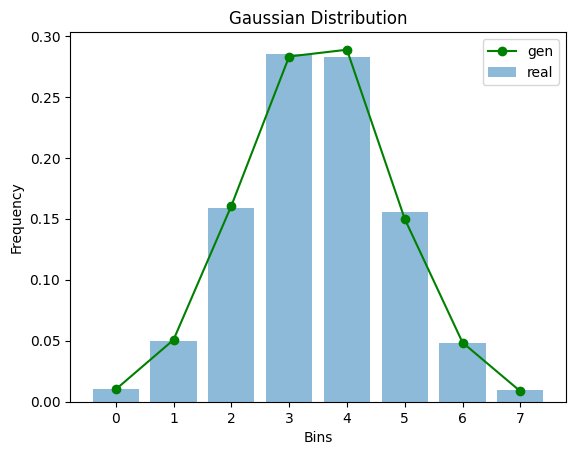

In [153]:
# load the model
generator = create_generator()
generator.load_state_dict(torch.load('generator.pth', map_location=torch.device('cpu')))
generator.eval()

# generate the distribution
gen_dist = generator(torch.tensor([[] for _ in range(125)])).detach().numpy()
# print(gen_dist)
# convert gen_dist 1D
# gen_dist = gen_dist * 1000
# data = np.random.normal(loc=3.5, scale=1, size=1000)
# normalize
print('Model loaded', gen_dist.shape)

# merge gen_dist into one average
gen_dist = gen_dist.mean(axis=0)
dataset_changed = np.array(dataset).mean(axis=0)

# Plot 10 histogram
import matplotlib.pyplot as plt
plt.plot(gen_dist, 'o-g', label='gen')
# plt.hist(data, bins=8, alpha=0.5, label='real',range=(0, 7))
plt.bar(range(len(dataset_changed)), dataset_changed, label='real', alpha=0.5)
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Gaussian Distribution')
plt.legend()
plt.show()
# print('Plot done')

# print(gen_dist)
# draw normal distribution using plt.hist


In [ ]:
# Why we design the circuit in this way?

# superposition + parameter ?

# How to back propagate the parameter?

# How to use the quantum feature to detect the minimum of the function?

# Gedeer Encoding

# EfficientSU2 ?